# TAR Project 2024 - Team Mojave

# Imports

In [1]:
import torch
import numpy as np
import pandas as pd
import logging
import time

from utils import log

# Config

In [2]:
MODEL_SAVE_DIR = './saved_models/'
LOG_DIR = './logs/'

logging.basicConfig()
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)


# Loading the questions and embeddings

In [4]:
from preprocessing import load_glove_embeddings, load_and_embed_questions, get_max_len

# Load embeddings and calculate the average embedding
glove_embeddings, glove_avg_embedding = load_glove_embeddings('glove-wikipedia/glove.6B.300d.txt', calculate_average=True)

In [5]:
result = load_and_embed_questions('data/train.csv', None, glove_embeddings, glove_avg_embedding)
print(len(result.vocab.idx_words))


Loading GloVe embeddings...DONE
Generating vocabulary...DONE
Extracting only embeddings required for vocabulary...DONE
6662


In [7]:
print(len(result.vocab.idx_words))

# Sanity check (should look like [-0.36886 0.16665 0.053452 ... -0.030849 -0.031811])
print(result.embedding[result.vocab.words_idx['year']])

6662
[-3.6886e-01  1.6665e-01  5.3452e-02  3.1654e-01 -1.5587e-01  3.7323e-01
  2.3476e-02 -7.7873e-02 -1.2866e-01 -1.4157e+00  4.2323e-01  1.0872e-01
  1.9566e-01 -3.6958e-02 -3.1716e-01  3.2313e-02 -1.0706e-01  1.5411e-01
 -1.1385e-01 -5.3492e-01 -8.8111e-02 -8.2342e-02 -1.1802e-02  5.7562e-02
 -2.5138e-01 -2.3305e-01 -1.4013e-01 -2.9804e-01  4.2330e-01  1.4148e-01
  2.1174e-01  3.0089e-03 -7.2124e-02  1.0726e-01 -1.4072e+00 -3.6393e-01
 -7.0648e-02 -3.5023e-02  9.2109e-03 -4.6376e-03  3.6941e-01 -3.1950e-01
 -4.0905e-01  8.1857e-02 -2.7848e-01 -2.3384e-01 -3.5798e-01  4.4094e-01
 -1.9289e-01  1.8111e-01  1.8372e-01 -1.7586e-01 -8.4658e-02  2.7628e-02
  2.4343e-01  2.2452e-01  9.2825e-02  1.8590e-01 -1.6946e-01 -2.1119e-01
 -4.8065e-01  2.3327e-02  3.2214e-01 -4.8864e-01 -4.5548e-02 -6.6230e-01
 -8.0392e-02  1.7008e-01 -8.6406e-02 -1.7071e-01  3.8116e-02  3.6805e-01
 -9.9032e-02  1.8643e-01 -2.5289e-02 -3.4840e-01  2.6928e-01 -4.0263e-01
 -4.1668e-01  4.0442e-01 -3.0187e-03 -1.2581e-

In [8]:
print('Calculating maximum question length...')
max_len = get_max_len(pd.read_csv('data/train.csv'))
print('Maximum length:', max_len)

Calculating maximum question length...
text parameter is not string, but <class 'float'>: nan
text parameter is not string, but <class 'float'>: nan
text parameter is not string, but <class 'float'>: nan
Maximum length: 89


# Dataset splits

In [9]:
from sklearn.model_selection import train_test_split

data = pd.read_csv('data/train.csv')

# Use 20% of data for the test set
train_df, test_df = train_test_split(data, test_size=0.2)
# Use 1/8 of the remaining for a 70/10/20 train/validation/test split
train_df, validation_df = train_test_split(train_df, test_size=0.125)

TRAIN_PATH = 'data/mojave/mojave_train.csv'
VALIDATION_PATH = 'data/mojave/mojave_validation.csv'
TEST_PATH = 'data/mojave/mojave_test.csv'

train_df.to_csv(TRAIN_PATH)
validation_df.to_csv(VALIDATION_PATH)
test_df.to_csv(TEST_PATH)

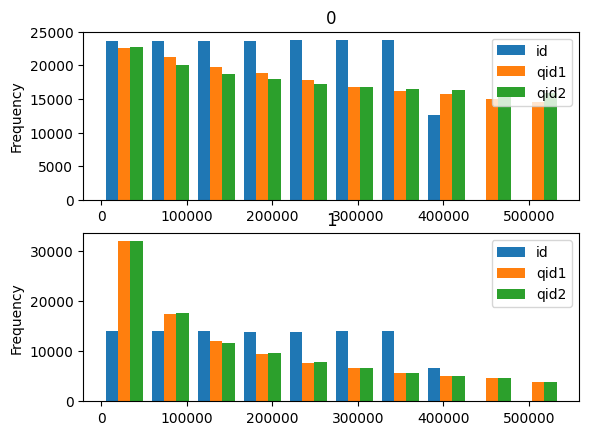

In [13]:
train_df.plot.hist(by='is_duplicate');

# Baseline models

In [14]:
from preprocessing import ProcessedResult, preprocess_text

def embedding_for_word(word: str, result: ProcessedResult) -> np.array:
    idx = None
    idx = result.vocab.words_idx.get(word, None)
    if idx is None:
        return result.avg_embedding
    return result.embedding[idx]

def question_embedding_tensor(text: str, result: ProcessedResult, device: torch.device) -> torch.Tensor:
    tokens = preprocess_text(text)
    token_embeddings = list(map(lambda token: embedding_for_word(token, result), tokens))
    if len(token_embeddings) == 0:
        token_embeddings = [np.array(result.avg_embedding)]
    token_embeddings = np.vstack(token_embeddings)
    return torch.from_numpy(token_embeddings.sum(axis=0)).to(device)

# Dataset splits

In [16]:
from torch import nn
from torch.utils.data import Dataset
from preprocessing import MojaveVocab
from typing import Any

questions_dtype = {
    'id': int,
    'qid1': int,
    'qid2': int,
    'question1': str,
    'question2': str,
    'is_duplicate': int
}

class QuestionPairDataset(Dataset):
    def __init__(self, questions_path: str, vocab: MojaveVocab, max_len: int, device: torch.device):
        self.path = questions_path
        self.vocab = vocab
        self.max_len = max_len
        self.device = device
        self.questions = pd.read_csv(questions_path, dtype=questions_dtype)
        # self.result = load_and_embed_questions(questions_path, None, glove_embeddings, glove_avg_embedding)
    def __len__(self):
        return len(self.questions)
    def __getitem__(self, index) -> Any:
        row = self.questions.iloc[index]
        question1 = preprocess_text(row['question1'])
        question2 = preprocess_text(row['question2'])
        label = row['is_duplicate']

        question1_idxs = [self.vocab.words_idx.get(word, self.vocab.unk_idx) for word in question1]
        question2_idxs = [self.vocab.words_idx.get(word, self.vocab.unk_idx) for word in question2]

        question1_idxs = question1_idxs + [self.vocab.pad_idx] * (self.max_len - len(question1_idxs))
        question2_idxs = question2_idxs + [self.vocab.pad_idx] * (self.max_len - len(question2_idxs))

        return (
            torch.tensor(question1_idxs, dtype=torch.long, device=self.device),
            torch.tensor(question2_idxs, dtype=torch.long, device=self.device),
            torch.tensor(label, dtype=torch.long, device=self.device)
        )

In [18]:
from torch.utils.data import DataLoader

BATCH_SIZE = 16
DEVICE = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.backends.cuda.is_available() else 'cpu'
device = torch.device(DEVICE)

train_data = QuestionPairDataset(questions_path=TRAIN_PATH, vocab=result.vocab, max_len=max_len, device=device)
validation_data = QuestionPairDataset(questions_path=VALIDATION_PATH, vocab=result.vocab, max_len=max_len, device=device)
test_data = QuestionPairDataset(questions_path=TEST_PATH, vocab=result.vocab, max_len=max_len, device=device)

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

# Model training

In [19]:
from models import QuestionPairMLP

def train_one_epoch(model: QuestionPairMLP, criterion: nn.CrossEntropyLoss, optimizer: torch.optim.Optimizer, training_loader: DataLoader, device: torch.device):
    validation_interval = 1000
    running_loss = 0.
    last_loss = 0.
    for i, data in enumerate(training_loader):
        question1, question2, labels = data

        optimizer.zero_grad()

        outputs = model(question1, question2)

        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            last_loss = running_loss / 100 # loss per batch
            log(logger, '  batch {} loss: {}'.format(i + 1, last_loss))
            running_loss = 0.
        if i % validation_interval == validation_interval - 1:
            running_vloss = 0.0
            # Set the model to evaluation mode, disabling dropout and using population
            # statistics for batch normalization.
            model.eval()

            # Disable gradient computation and reduce memory consumption.
            with torch.no_grad():
                for i, vdata in enumerate(validation_dataloader):
                    vq1, vq2, vlabels = vdata
                    voutputs = model(vq1, vq2)
                    vloss = criterion(voutputs, vlabels)
                    running_vloss += vloss

            avg_vloss = running_vloss / (i + 1)
            log(logger, 'LOSS valid {}'.format(avg_vloss))
        model.train(True)
            
    return last_loss


In [21]:
HIDDEN_LAYER_SIZE_1 = 128
HIDDEN_LAYER_SIZE_2 = 64
EPOCHS = 1
LR = 1e-4
WD = 0.1

model = QuestionPairMLP(len(result.vocab), result.embedding, 300, HIDDEN_LAYER_SIZE_1, HIDDEN_LAYER_SIZE_2, device)
model.to(device)

# Logging setup
timestamp = str(int(time.time()))
fh = logging.FileHandler(LOG_DIR + timestamp + '_mlp.log')
fh.setLevel(logging.DEBUG)
logger.handlers.clear()
logger.addHandler(fh)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR, weight_decay=WD)

log(logger, 'Run at timestamp: ' + timestamp)
log(logger, f'Total params: {sum(parameter.numel() for parameter in model.parameters() if parameter.requires_grad)}')
log(logger, f'HIDDEN_LAYER_SIZE_1: {HIDDEN_LAYER_SIZE_1}')
log(logger, f'HIDDEN_LAYER_SIZE_2: {HIDDEN_LAYER_SIZE_2}')
log(logger, f'LR = {LR}')
log(logger, f'WD = {WD}')

for epoch in range(EPOCHS):
    log(logger, f'EPOCH {epoch}')

    model.train(True)
    avg_loss = train_one_epoch(model, criterion, optimizer, train_dataloader, device)

torch.save(model.state_dict(), MODEL_SAVE_DIR + timestamp + '.model')

print('DONE with training')

Run at timestamp: 1716733115
Total params: 85314
HIDDEN_LAYER_SIZE_1: 128
HIDDEN_LAYER_SIZE_2: 64
LR = 0.0001
WD = 0.1
EPOCH 0
  batch 100 loss: 0.6761941587924958
  batch 200 loss: 0.6782734596729278
  batch 300 loss: 0.6793051534891128
  batch 400 loss: 0.6770786172151566
  batch 500 loss: 0.6803968930244446
  batch 600 loss: 0.6764743041992187
  batch 700 loss: 0.677337054014206
  batch 800 loss: 0.6756083422899246
  batch 900 loss: 0.6778529155254364
  batch 1000 loss: 0.6790100526809693
text parameter is not string, but <class 'float'>: nan
LOSS valid 0.67635178565979
  batch 1100 loss: 0.6800547695159912
  batch 1200 loss: 0.6726067370176315
  batch 1300 loss: 0.6738550990819931
  batch 1400 loss: 0.6764506411552429
text parameter is not string, but <class 'float'>: nan
  batch 1500 loss: 0.674996309876442
  batch 1600 loss: 0.6741819626092911
  batch 1700 loss: 0.6740669453144074
  batch 1800 loss: 0.6773726505041122
  batch 1900 loss: 0.6780846983194351
  batch 2000 loss: 0.673

In [23]:
running_tloss = 0.

correct_pred = 0
total_pred = len(test_data)

model.eval()
with torch.no_grad():
    for i, tdata in enumerate(test_dataloader):
        tq1, tq2, tlabels = tdata
        toutputs = model(tq1, tq2)
        prob_toutputs = nn.functional.softmax(toutputs, dim=1)
        prediction = torch.zeros_like(prob_toutputs)
        mask = toutputs > 0.5
        prediction[mask] = 1.
        prediction = prediction[:, 0]
        correct_pred += int(torch.sum((prediction == tlabels) * (prediction == 1.)).float())
        total_pred += prediction.size(0)
        tloss = criterion(toutputs, tlabels)
        running_tloss += tloss
total = i + 1
avg_tloss = running_tloss / total
accuracy = correct_pred / total_pred


text parameter is not string, but <class 'float'>: nan


In [24]:
# avg_tloss
accuracy

0.0

In [26]:
from models import QuestionPairCosineSimilarity

EPOCHS = 1
LR = 1e-5

cos_model = QuestionPairCosineSimilarity(len(result.vocab), result.embedding, 300, device)
cos_model.to(device)

# Logging setup
timestamp = str(int(time.time()))
fh = logging.FileHandler(LOG_DIR + timestamp + '_cos.log')
fh.setLevel(logging.DEBUG)
logger.handlers.clear()
logger.addHandler(fh)

log(logger, 'Run timestamp: ' + timestamp)
log(logger, f'EPOCHS: {EPOCHS}')
log(logger, f'LR = {LR}')

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cos_model.parameters(), lr=LR)

for epoch in range(EPOCHS):
    cos_model.train()

    running_loss = 0.
    last_loss = 0.

    for i, data in enumerate(train_dataloader):
        # Get inputs and labels
        q1, q2, labels = data
        
        optimizer.zero_grad()
        
        outputs = cos_model(q1, q2)
        
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * q1.size(0)

        if i % 100 == 99:
            last_loss = running_loss / 100 # loss per batch
            log(logger, '  batch {} loss: {}'.format(i + 1, last_loss))
            running_loss = 0.

    running_vloss = 0.
    
    cos_model.eval()

    with torch.no_grad():
        for i, vdata in enumerate(validation_dataloader):
            vq1, vq2, vlabels = vdata
            voutputs = cos_model(vq1, vq2)
            vloss = criterion(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    log(logger, 'LOSS train {} valid {}'.format(avg_loss, avg_vloss))
    
    epoch_loss = running_loss / len(train_dataloader.dataset)
    log(logger, f"Epoch [{epoch+1}/{EPOCHS}], Loss: {epoch_loss:.4f}")


Run timestamp: 1716734587
EPOCHS: 1
LR = 1e-05
  batch 100 loss: 13.125542163848877
  batch 200 loss: 13.084531574249267
  batch 300 loss: 13.01950047492981
  batch 400 loss: 13.44168363571167
  batch 500 loss: 13.15376296043396
  batch 600 loss: 13.1065620803833
  batch 700 loss: 13.172521514892578
  batch 800 loss: 13.176909551620483
  batch 900 loss: 13.132677526474
  batch 1000 loss: 13.117112083435059
  batch 1100 loss: 13.265741348266602
  batch 1200 loss: 13.09733465194702
  batch 1300 loss: 13.094244260787963
  batch 1400 loss: 13.01409460067749
  batch 1500 loss: 13.022502641677857
  batch 1600 loss: 12.835916185379029
  batch 1700 loss: 13.016829757690429
  batch 1800 loss: 13.062206964492798
  batch 1900 loss: 13.228605394363404
  batch 2000 loss: 13.041410112380982
  batch 2100 loss: 13.02677752494812
  batch 2200 loss: 12.912434816360474
  batch 2300 loss: 12.917502946853638
  batch 2400 loss: 13.07784942626953
  batch 2500 loss: 13.19842155456543
  batch 2600 loss: 12.909

In [27]:
running_tloss = 0.

correct_preds = 0
total_preds = 0

cos_model.eval()
with torch.no_grad():
    for i, tdata in enumerate(test_dataloader):
        tq1, tq2, tlabels = tdata
        toutputs = cos_model(tq1, tq2)
        prob_toutputs = nn.functional.softmax(toutputs, dim=1)
        prediction = torch.zeros_like(prob_toutputs)
        mask = prob_toutputs > 0.5
        prediction[mask] = 1.
        prediction = prediction[:, 0]
        correct_preds += int(torch.sum((prediction == tlabels) * (prediction == 1.)).float())
        total_preds += prediction.size(0)
        tloss = criterion(toutputs, tlabels)
        running_tloss += tloss
total = i + 1
avg_tloss = running_tloss / total
accuracy = correct_preds / total_preds
print(accuracy)

text parameter is not string, but <class 'float'>: nan
0.32549654950654233
